# OpenEarhMap Semantinc Segmentation

original implementation found at https://github.com/bao18/open_earth_map/blob/main/Demo.ipynb

---

### Requirements

In [2]:
!pip install git+https://github.com/bao18/open_earth_map

  Cloning https://github.com/bao18/open_earth_map to /private/var/folders/2d/gysnzb3n1912sxr699qq0pfm0000gn/T/pip-req-build-sn_umqce
  Running command git clone --filter=blob:none --quiet https://github.com/bao18/open_earth_map /private/var/folders/2d/gysnzb3n1912sxr699qq0pfm0000gn/T/pip-req-build-sn_umqce
  Resolved https://github.com/bao18/open_earth_map to commit c525cbd65eb69cbb2e21b5681cf2e7ed25d57f6c
  Preparing metadata (setup.py) ... done
  Using cached rasterio-1.3.4-cp39-cp39-macosx_10_15_x86_64.whl (30.9 MB)
  Using cached gdown-4.6.0-py3-none-any.whl (14 kB)
  Using cached opencv_python-4.7.0.68-cp37-abi3-macosx_10_13_x86_64.whl (51.7 MB)
  Using cached requests-2.28.2-py3-none-any.whl (62 kB)
  Using cached filelock-3.9.0-py3-none-any.whl (9.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.1 MB/s eta 0:00:00
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached beautifulsoup4-4.11.1-py3-none-any.whl (128 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
# import gdown
# import zipfile

# url = "https://drive.google.com/uc?export=download&confirm=pbef&id=1SqLqv1RCJdiUFnnfIce78M9nJF_KF11U"
# output = "OpenEathMap_Mini.zip"
# gdown.download(url, output, quiet=False)

# with zipfile.ZipFile(output, 'r') as fzip:
#     fzip.extractall()
# os.remove(output)

### Imports
---

In [3]:
import time
import warnings
import numpy as np
import torch
import rasterio
import cv2
import open_earth_map as oem
import torchvision
from pathlib import Path
import matplotlib.pyplot as plt
import os

warnings.filterwarnings("ignore")

### Defines main parameters

In [14]:
# Path to the OpenEarthMap directory
OEM_DATA_DIR = "OpenEarthMap_wo/"

# Training and validation file list
TRAIN_LIST = os.path.join(OEM_DATA_DIR, "train.txt")
VAL_LIST = os.path.join(OEM_DATA_DIR, "val.txt")

IMG_SIZE = 512
#buildingと背景
N_CLASSES = 2
LR = 0.0001
BATCH_SIZE = 4
NUM_EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_DIR = "outputs"
TASK = "building"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Prepares training and validation file lists.

In [15]:
fns = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
train_fns = [str(f) for f in fns if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_fns = [str(f) for f in fns if f.name in np.loadtxt(VAL_LIST, dtype=str)]

print("Total samples      :", len(fns))
print("Training samples   :", len(train_fns))
print("Validation samples :", len(val_fns))

Total samples      : 3873
Training samples   : 2303
Validation samples : 384


### Prepares training and validation augmentations.

In [16]:
train_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Rotate(),
        oem.transforms.Crop(IMG_SIZE),
    ],
)

val_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Resize(IMG_SIZE),
    ],
)

### Defines training and validation dataloaders

In [17]:
train_data = oem.dataset.OpenEarthMapDataset(
    train_fns,
    n_classes=N_CLASSES,
    augm=train_augm,
    task = TASK
)

val_data = oem.dataset.OpenEarthMapDataset(
    val_fns,
    n_classes=N_CLASSES,
    augm=val_augm,
    task = TASK
)

OpenEarthMap_wo/khartoum/images/khartoum_11.tif
OpenEarthMap_wo/khartoum/images/khartoum_41.tif
OpenEarthMap_wo/khartoum/images/khartoum_49.tif
OpenEarthMap_wo/khartoum/images/khartoum_10.tif
OpenEarthMap_wo/khartoum/images/khartoum_55.tif


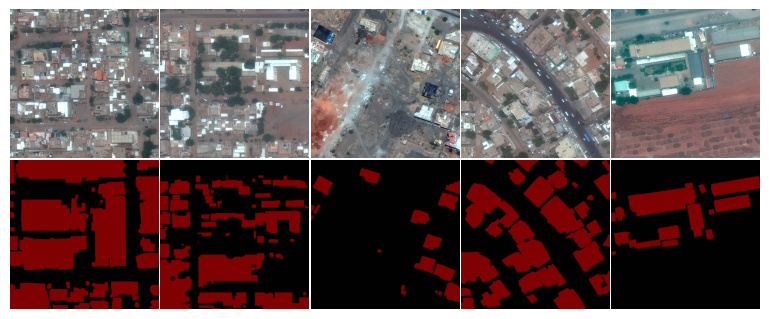

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(5*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

IDX = 1
for i in range(5):
    img, msk, fn = val_data[i]
    print(fn)
    img = np.moveaxis(img.numpy(), 0, -1)
    msk = oem.utils.make_rgb(np.argmax(msk.numpy(), axis=0))
    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
    axs[1, i].axis("off")

plt.show()

In [19]:
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)

val_data_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=False,
)

### Defines the network architecture, optimizer, and criterion

In [20]:
network = oem.networks.UNetFormer(in_channels=3, n_classes=N_CLASSES)
optimizer = torch.optim.Adam(network.parameters(), lr=LR)
criterion = oem.losses.JaccardLoss()


### Trains and validates the network

In [11]:
start = time.time()

max_score = 0
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch: {epoch + 1}")

    train_logs = oem.runners.train_epoch(
        model=network,
        optimizer=optimizer,
        criterion=criterion,
        dataloader=train_data_loader,
        device=DEVICE,
    )

    valid_logs = oem.runners.valid_epoch(
        model=network,
        criterion=criterion,
        dataloader=val_data_loader,
        device=DEVICE,
    )
    
    epoch_score = valid_logs["Score"]
    if max_score < epoch_score:
        max_score = epoch_score
        oem.utils.save_model(
            model=network,
            epoch=epoch,
            best_score=max_score,
            model_name="model.pth",
            output_dir=OUTPUT_DIR,
        )

print("Elapsed time: {:.3f} min".format((time.time() - start) / 60.0))


Epoch: 1


Train:   0%|          | 0/575 [00:03<?, ?it/s]


KeyboardInterrupt: 

# Testing 

### Prepares testing files

In [21]:
TEST_LIST = os.path.join(OEM_DATA_DIR, "val.txt")
PREDS_DIR = "predictions_kasika"
os.makedirs(PREDS_DIR, exist_ok=True)

img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
test_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TEST_LIST, dtype=str)]

print("Total samples   :", len(img_paths))
print("Testing samples :", len(test_fns))

Total samples   : 3873
Testing samples : 384


In [22]:
test_fns

['OpenEarthMap_wo/khartoum/images/khartoum_11.tif',
 'OpenEarthMap_wo/khartoum/images/khartoum_41.tif',
 'OpenEarthMap_wo/khartoum/images/khartoum_49.tif',
 'OpenEarthMap_wo/khartoum/images/khartoum_10.tif',
 'OpenEarthMap_wo/khartoum/images/khartoum_55.tif',
 'OpenEarthMap_wo/khartoum/images/khartoum_31.tif',
 'OpenEarthMap_wo/khartoum/images/khartoum_64.tif',
 'OpenEarthMap_wo/podlaskie/images/podlaskie_4.tif',
 'OpenEarthMap_wo/muenster/images/muenster_6.tif',
 'OpenEarthMap_wo/muenster/images/muenster_39.tif',
 'OpenEarthMap_wo/muenster/images/muenster_29.tif',
 'OpenEarthMap_wo/muenster/images/muenster_18.tif',
 'OpenEarthMap_wo/muenster/images/muenster_67.tif',
 'OpenEarthMap_wo/muenster/images/muenster_1.tif',
 'OpenEarthMap_wo/muenster/images/muenster_47.tif',
 'OpenEarthMap_wo/kampala/images/kampala_2.tif',
 'OpenEarthMap_wo/ica/images/ica_10.tif',
 'OpenEarthMap_wo/ica/images/ica_50.tif',
 'OpenEarthMap_wo/ica/images/ica_32.tif',
 'OpenEarthMap_wo/ica/images/ica_16.tif',
 'Op

### Defines test dataloader

In [24]:
test_data = oem.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES, augm=None, task = TASK)


### Loads trained network

In [28]:
network = oem.networks.UNetFormer(in_channels=3, n_classes=N_CLASSES,backbone_name="seresnet152d")
network = oem.utils.load_checkpoint(network, model_name="unetformer_model_building_100.pth", model_dir="outputs")

Loaded model:unetformer_model_building_100.pth (Epoch=88, Score=0.732)


### Makes predictions

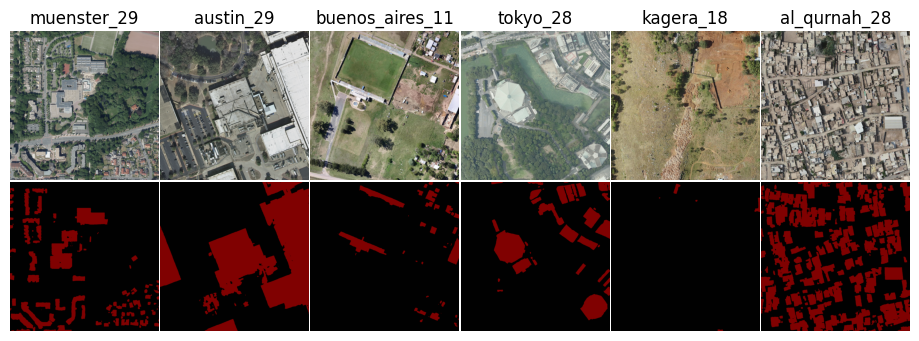

In [29]:
NPLOT = 6
idxs = np.argsort(np.random.rand(len(test_fns)))[:NPLOT]

fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, fn = test_data[idx][0], test_data[idx][2]

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()
    prd = oem.utils.make_rgb(np.argmax(prd.numpy(), axis=0))

    fout = os.path.join(PREDS_DIR, fn.split("/")[-1])
    with rasterio.open(fn, "r") as src:
        profile = src.profile
        prd = cv2.resize(
            prd,
            (profile["width"], profile["height"]),
            interpolation=cv2.INTER_NEAREST,
        )
        with rasterio.open(fout, "w", **profile) as dst:
            for idx in src.indexes:
                dst.write(prd[:, :, idx - 1], idx)

    img = np.moveaxis(img.numpy(), 0, -1)
    axs[0, i].imshow(img)
    axs[0, i].set_title(fn.split("/")[-1][:-4])    
    axs[0, i].axis("off")
    axs[1, i].imshow(prd)
    axs[1, i].axis("off")
plt.show()

In [74]:
l

[tensor(0.3158, device='cuda:0'),
 tensor(0.0153, device='cuda:0'),
 tensor(0.0493, device='cuda:0'),
 tensor(6.4757e-12, device='cuda:0'),
 tensor(0.4645, device='cuda:0'),
 tensor(1.8284e-13, device='cuda:0'),
 tensor(9.3040e-13, device='cuda:0'),
 tensor(0.1052, device='cuda:0')]

In [65]:
idxs = len(test_fns)


network.eval().to(DEVICE)
li = []
for i in range(idxs):
    img, msk, fn = test_data[i][0],test_data[i][1] ,test_data[i][2]
    print(fn)
    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE))
        # print(prd.size(), type(msk))
        msk = msk.unsqueeze(0).to(DEVICE)
        loss, l= criterion(prd,msk)
        li.append(l)

OpenEarthMap_wo/khartoum/images/khartoum_11.tif
OpenEarthMap_wo/khartoum/images/khartoum_41.tif
OpenEarthMap_wo/khartoum/images/khartoum_49.tif
OpenEarthMap_wo/khartoum/images/khartoum_10.tif
OpenEarthMap_wo/khartoum/images/khartoum_55.tif
OpenEarthMap_wo/khartoum/images/khartoum_31.tif
OpenEarthMap_wo/khartoum/images/khartoum_64.tif


KeyboardInterrupt: 

In [37]:
li[0]

[tensor(4.0041e-11, device='cuda:0'),
 tensor(0.4939, device='cuda:0'),
 tensor(0.3796, device='cuda:0'),
 tensor(0.5357, device='cuda:0'),
 tensor(0.6012, device='cuda:0'),
 tensor(0.0827, device='cuda:0'),
 tensor(0.0806, device='cuda:0'),
 tensor(0.8468, device='cuda:0')]

In [44]:
li[1]

[tensor(4.0041e-11, device='cuda:0'),
 tensor(0.4939, device='cuda:0'),
 tensor(0.3796, device='cuda:0'),
 tensor(0.5357, device='cuda:0'),
 tensor(0.6012, device='cuda:0'),
 tensor(0.0827, device='cuda:0'),
 tensor(0.0806, device='cuda:0'),
 tensor(0.8468, device='cuda:0')]

In [59]:

li_in = [tensor.cpu().item() for tensor in li[i]]

In [60]:
hoge = []
for i in range(len(li)):
    hoge.append([tensor.cpu().item() for tensor in li[i]])

In [61]:
a = np.array(hoge)
aa = np.mean(a,axis=0)

In [62]:
aa

array([0.02890629, 0.32644283, 0.32235749, 0.41675515, 0.50190931,
       0.09290179, 0.17462165, 0.59051817])

In [68]:
a[0:5]

array([[1.71844147e-12, 1.14532550e-11, 2.70623952e-01, 1.92741066e-01,
        6.57907426e-01, 1.29377259e-10, 4.17718471e-10, 3.67038429e-01],
       [2.06552923e-01, 1.64890692e-12, 3.23879898e-01, 2.45129332e-01,
        4.81870949e-01, 9.43547185e-11, 3.21308025e-09, 3.44104648e-01],
       [2.30406948e-13, 1.53550662e-11, 4.10815269e-01, 3.19864787e-02,
        3.11242163e-01, 4.20154840e-12, 3.96635969e-09, 4.47558045e-01],
       [3.40726861e-12, 1.05535902e-01, 3.92237574e-01, 4.98388946e-01,
        6.12099051e-01, 1.81872989e-11, 6.19875054e-11, 3.95702422e-01],
       [6.17707789e-01, 7.82612041e-02, 7.94389322e-02, 6.43880478e-12,
        4.54720587e-01, 3.01655646e-13, 4.54926807e-09, 1.14409544e-01]])

In [64]:
a[1]

array([2.06552923e-01, 1.64890692e-12, 3.23879898e-01, 2.45129332e-01,
       4.81870949e-01, 9.43547185e-11, 3.21308025e-09, 3.44104648e-01])